In [1]:
seed_value = 0

# Import DeepInsight
import sys
sys.path.insert(0, "/home/marx/Documents/Github/DeepInsight")
import deepinsight
# Choose GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['PYTHONHASHSEED']=str(0)
import tensorflow as tf
tf.random.set_seed(seed_value)
# Also numpy random generator
import numpy as np
np.random.seed(seed_value)

import numpy as np
import h5py
%load_ext autoreload
%autoreload 2

In [ ]:
%run run_test.py

Starting wavelet transformation (n=300000, chunks=5, frequencies=26)
5/5 [==============================] - 10s 2s/chunk
Successfully written Dataset="aligned" to /home/marx/Documents/Github/DeepInsight/tests/tests/test_files/test.h5
------------------------------------------------
-> Running test.h5 from /home/marx/Documents/Github/DeepInsight/tests/tests/test_files
- Logs : /home/marx/Documents/Github/DeepInsight/tests/tests/test_files/logs/test 
- Model temporary : /home/marx/Documents/Github/DeepInsight/tests/tests/test_files/models/tmp/tmp_model 
- Model : /home/marx/Documents/Github/DeepInsight/tests/tests/test_files/models/test_model.h5
------------------------------------------------
------------------------------------------------
Starting standard model
------------------------------------------------
------------------------------------------------
-> Model and generators loaded
------------------------------------------------
Epoch 1/2
10/10 [==============================]

In [2]:
fp_deepinsight = './test_files/test.h5'
if os.path.exists(fp_deepinsight):
    os.remove(fp_deepinsight)
input_length = int(3e5)
input_channels = 5
sampling_rate = 30000
input_output_ratio = 100

np.random.seed(0)
rand_input = np.sin(np.random.rand(int(input_length), input_channels))
rand_input_timesteps = np.arange(0, input_length)
rand_output = np.random.rand(input_length // input_output_ratio)
rand_timesteps = np.arange(0, input_length, input_output_ratio)

print(rand_input[0,0])
print(rand_input_timesteps[0:10])
print(rand_output[0])
print(rand_timesteps[0:10])

0.5216753442582844
[0 1 2 3 4 5 6 7 8 9]
0.7039485667507264
[  0 100 200 300 400 500 600 700 800 900]


In [3]:
# Transform raw data to frequency domain
deepinsight.preprocess.preprocess_input(fp_deepinsight, rand_input, sampling_rate=sampling_rate, average_window=10)

# Test cases
hdf5_file = h5py.File(fp_deepinsight, mode='r')
# Get size of wavelets
input_wavelets = hdf5_file['inputs/wavelets']
# Check statistics of wavelets
np.testing.assert_almost_equal(np.mean(input_wavelets), 0.048329726)
np.testing.assert_almost_equal(np.std(input_wavelets), 0.032383125)
np.testing.assert_almost_equal(np.median(input_wavelets), 0.04608967)
np.testing.assert_almost_equal(np.max(input_wavelets), 0.40853173)
np.testing.assert_almost_equal(np.min(input_wavelets), 1.6544704e-05)
hdf5_file.close()


Starting wavelet transformation (n=300000, chunks=5, frequencies=26)
5/5 [==============================] - 13s 2s/chunk


AssertionError: 
Arrays are not almost equal to 7 decimals
 ACTUAL: 0.0466799
 DESIRED: 0.032383125

In [9]:
print('Mean {:.10}, Std {:.10}, Median {:.10}, Max {:.10}, Min {:.10}'.format(np.mean(input_wavelets), np.std(input_wavelets), np.median(input_wavelets), np.max(input_wavelets), np.min(input_wavelets)))

Mean 0.04832971096, Std 0.0466798991, Median 0.0344029367, Max 0.6036593318, Min 3.78198024e-08


In [12]:
# Prepare outputs
deepinsight.preprocess.preprocess_output(fp_deepinsight, rand_input_timesteps, rand_output,
                                           rand_timesteps)

In [16]:
# Define loss functions and train model
loss_functions = {'output_aligned' : 'mse'}
loss_weights = {'output_aligned' : 1}
user_opts = {'epochs' : 2, 'steps_per_epoch' : 10, 'validation_steps' : 10, 'log_output' : False, 'save_model' : False}

deepinsight.train.run_from_path(fp_deepinsight, loss_functions, loss_weights, user_opts)

------------------------------------------------
-> Running test.h5 from ./test_files
- Logs : ./test_files/logs/test 
- Model temporary : ./test_files/models/tmp/tmp_model 
- Model : ./test_files/models/test_model.h5
------------------------------------------------
------------------------------------------------
Starting standard model
------------------------------------------------
------------------------------------------------
-> Model and generators loaded
------------------------------------------------
Epoch 1/2
10/10 [==============================] - 2s 171ms/step - loss: 0.2380 - val_loss: 0.2742
Epoch 2/2
10/10 [==============================] - 1s 77ms/step - loss: 0.1059 - val_loss: 0.1265
------------------------------------------------
-> Model_0 saved to ./test_files/models/test_model_0.h5
------------------------------------------------
------------------------------------------------
-> Model and generators loaded
------------------------------------------------
Ep

In [6]:
# Get loss and shuffled loss for influence plot, both is also stored back to HDF5 file
losses, output_predictions, indices = deepinsight.analyse.get_model_loss(fp_deepinsight, stepsize=10)

# Test cases
np.testing.assert_almost_equal(losses[-1], 1.0168755e-05)
np.testing.assert_almost_equal(losses[0], 0.53577816)
np.testing.assert_almost_equal(np.mean(losses), 0.09069238)
np.testing.assert_almost_equal(np.std(losses), 0.13594063)
np.testing.assert_almost_equal(np.median(losses), 0.045781307)
np.testing.assert_almost_equal(np.max(losses), 0.53577816)
np.testing.assert_almost_equal(np.min(losses), 1.0168755e-05)


5/5 [==============================] - 2s 490ms/run


AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 0.07960954
Max relative difference: 7828.83800765
 x: array([0.0796197], dtype=float32)
 y: array(1.0168755e-05)

In [17]:
shuffled_losses = deepinsight.analyse.get_shuffled_model_loss(fp_deepinsight, axis=1,stepsize=10)

# Test cases
np.testing.assert_almost_equal(np.mean(shuffled_losses), 0.09304095)
np.testing.assert_almost_equal(np.std(shuffled_losses), 0.13982493)
np.testing.assert_almost_equal(np.median(shuffled_losses), 0.04165206)
np.testing.assert_almost_equal(np.max(shuffled_losses), 0.7405345)
np.testing.assert_almost_equal(np.min(shuffled_losses), 2.0834877e-07)

26/26 [==============================] - 77s 3s/run


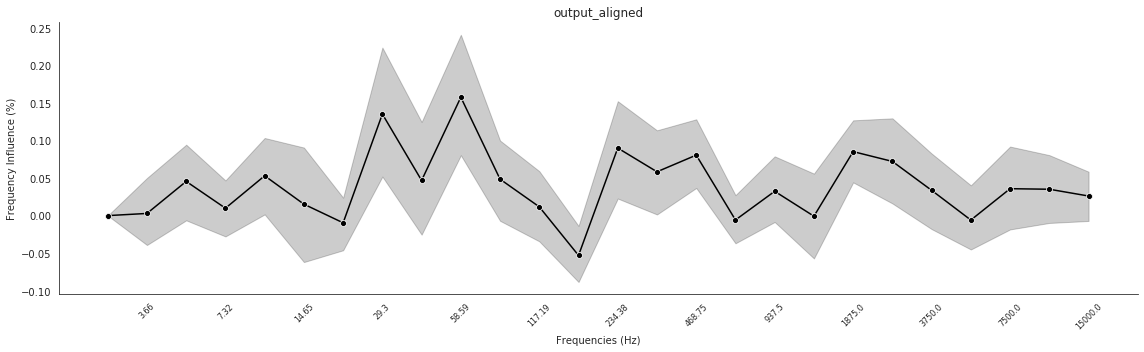

In [8]:
deepinsight.visualize.plot_residuals(fp_deepinsight, frequency_spacing=2,
                                     output_names=['output_aligned'])